In [39]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [151]:
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import math
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import missingno as msno
import efficientnet.tfkeras as efn
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import iplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping, LearningRateScheduler

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [128]:
train_csv = pd.read_csv("/Users/rathore/Downloads/archive (3)/Training_set.csv")
test_csv = pd.read_csv("/Users/rathore/Downloads/archive (3)/Testing_set.csv")

In [129]:
def shape_of_ds(df, ds_name='df'):
    print(f"{ds_name} dataset has {df.shape[0]} rows and {df.shape[1]} columns")
    
def check_null(df, ds_name='df'):
    print(f"Number of null values in the {ds_name} dataset: ")
    print(df.isnull().sum())

def unique_vals(df, ds_name='df'):
    print(f"Number of unique values in {ds_name} dataset: ")
    print(df.nunique())
    
def seperator(sep=50):
    print("-"*sep)

In [130]:
train_csv.head()

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


In [131]:
test_csv.head()

,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg


In [132]:
shape_of_ds(train_csv, "Train")
shape_of_ds(test_csv, "Test")

Train dataset has 6499 rows and 2 columns
Test dataset has 2786 rows and 1 columns


In [133]:
train_csv['filename'] = '/Users/rathore/Downloads/archive (3)/train/' + train_csv['filename']
test_csv['filename'] = '/Users/rathore/Downloads/archive (3)/test/' + test_csv['filename']

In [134]:
train_size = 0.75
train_df, valid_df = train_test_split(train_csv,  train_size= train_size, shuffle= True, random_state= 123)

In [146]:
train_csv.count()

filename    6499
label       6499
dtype: int64

In [147]:
test_csv.count()

filename    2786
dtype: int64

In [148]:
train_df.count()

filename    4874
label       4874
dtype: int64

In [149]:
valid_df.count()

filename    1625
label       1625
dtype: int64

In [135]:
train_df.head()

,filename,label
5575,/Users/rathore/Downloads/archive (3)/train/Ima...,COMMON WOOD-NYMPH
1302,/Users/rathore/Downloads/archive (3)/train/Ima...,INDRA SWALLOW
3222,/Users/rathore/Downloads/archive (3)/train/Ima...,TROPICAL LEAFWING
3374,/Users/rathore/Downloads/archive (3)/train/Ima...,CHECQUERED SKIPPER
1094,/Users/rathore/Downloads/archive (3)/train/Ima...,BLACK HAIRSTREAK


In [136]:
valid_df.head()

,filename,label
2482,/Users/rathore/Downloads/archive (3)/train/Ima...,MOURNING CLOAK
5148,/Users/rathore/Downloads/archive (3)/train/Ima...,EASTERN DAPPLE WHITE
941,/Users/rathore/Downloads/archive (3)/train/Ima...,GREEN CELLED CATTLEHEART
970,/Users/rathore/Downloads/archive (3)/train/Ima...,DANAID EGGFLY
4899,/Users/rathore/Downloads/archive (3)/train/Ima...,EASTERN PINE ELFIN


In [137]:
shape_of_ds(train_df, "Train")
shape_of_ds(valid_df, "Valid")

Train dataset has 4874 rows and 2 columns
Valid dataset has 1625 rows and 2 columns


In [138]:
def count_plot(x, df, title, xlabel, ylabel, width, height, order = None, rotation=False, palette='winter', hue=None):
    ncount = len(df)
    plt.figure(figsize=(width,height))
    ax = sns.countplot(x = x, palette=palette, order = order, hue=hue)
    plt.title(title, fontsize=20)
    if rotation:
        plt.xticks(rotation = 'vertical')
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.show()

In [139]:
train_order = train_df['label'].value_counts()
train_order

MOURNING CLOAK               90
ORANGE TIP                   81
SCARCE SWALLOW               81
EASTERN PINE ELFIN           80
BROWN SIPROETA               76
                             ..
MALACHITE                    52
CRIMSON PATCH                52
AFRICAN GIANT SWALLOWTAIL    51
WOOD SATYR                   51
ELBOWED PIERROT              50
Name: label, Length: 75, dtype: int64

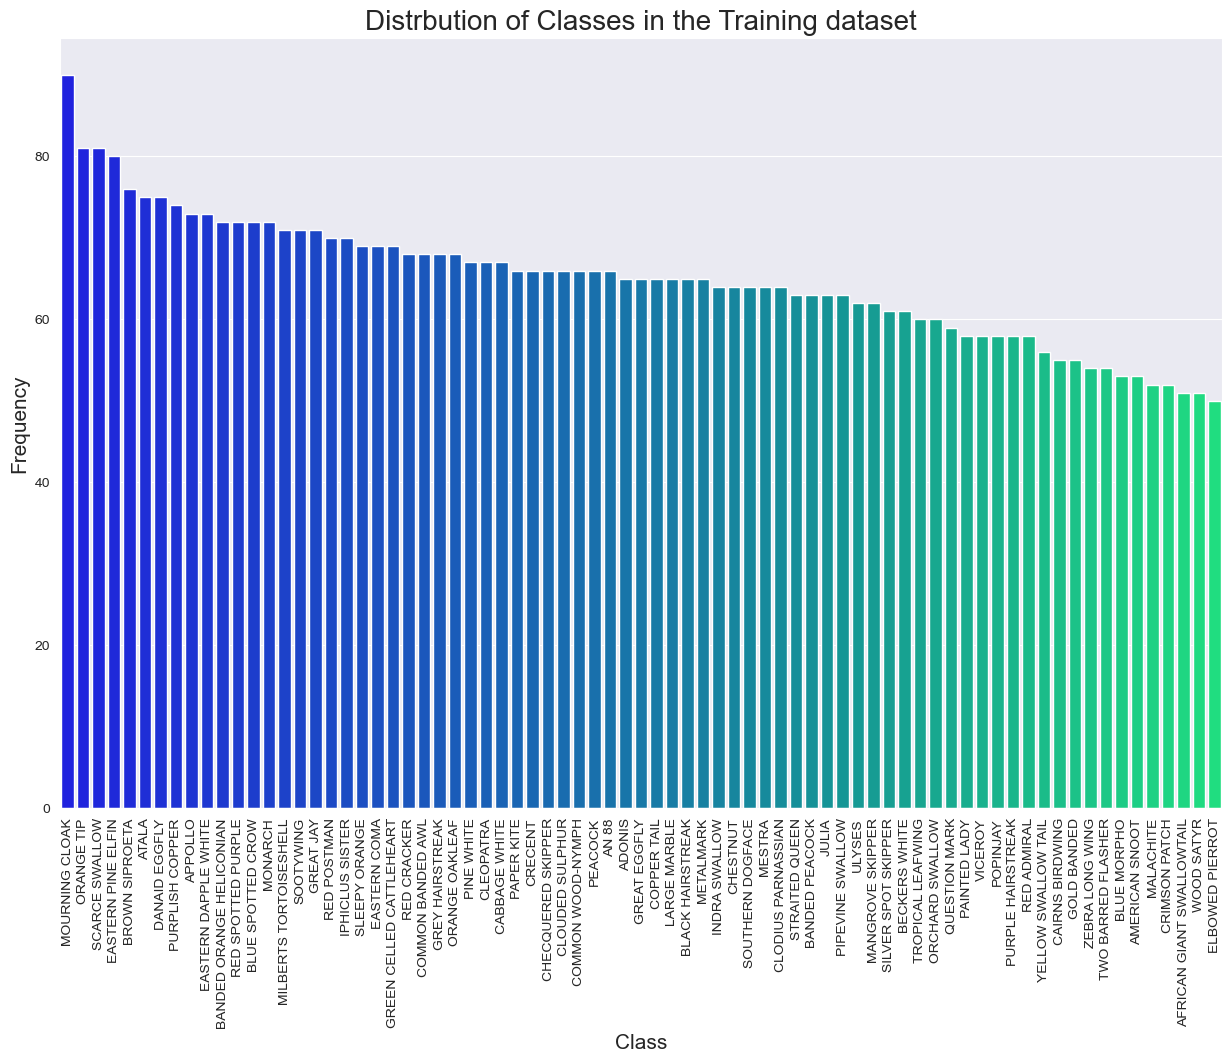

In [140]:
x = train_df['label']
count_plot(x, train_df, "Distrbution of Classes in the Training dataset", 'Class', 'Frequency', 15,10, order = train_order.index, rotation=True)

In [141]:
batch_size = 16
img_size = (128, 128)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_csv)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

print(ts_length)
print(test_batch_size)
print(test_steps)

2786
14
199


In [142]:
train_df['filename'][0]

'/Users/rathore/Downloads/archive (3)/train/Image_1.jpg'

In [143]:
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar,
                            rotation_range=15,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.1,
                            brightness_range=[0.5, 1.5],
                            horizontal_flip=True,
                            vertical_flip=True)

ts_gen = ImageDataGenerator(preprocessing_function= scalar,
                            rotation_range=15,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.1,
                            brightness_range=[0.5, 1.5],
                            horizontal_flip=True,
                            vertical_flip=True)
train_gen = tr_gen.flow_from_dataframe( train_df, 
                                        x_col= 'filename', 
                                        y_col= 'label', 
                                        target_size= img_size, 
                                        class_mode= 'categorical',
                                        color_mode= 'rgb', 
                                        shuffle= True, 
                                        batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, 
                                       x_col= 'filename', 
                                       y_col= 'label', 
                                       target_size= img_size, 
                                       class_mode= 'categorical',
                                       color_mode= 'rgb', 
                                       shuffle= True, 
                                       batch_size= batch_size)


Found 4874 validated image filenames belonging to 75 classes.
Found 1625 validated image filenames belonging to 75 classes.


In [144]:
print(train_df.head())
print(valid_df.head())

                                               filename               label
5575  /Users/rathore/Downloads/archive (3)/train/Ima...   COMMON WOOD-NYMPH
1302  /Users/rathore/Downloads/archive (3)/train/Ima...       INDRA SWALLOW
3222  /Users/rathore/Downloads/archive (3)/train/Ima...   TROPICAL LEAFWING
3374  /Users/rathore/Downloads/archive (3)/train/Ima...  CHECQUERED SKIPPER
1094  /Users/rathore/Downloads/archive (3)/train/Ima...    BLACK HAIRSTREAK
                                               filename  \
2482  /Users/rathore/Downloads/archive (3)/train/Ima...   
5148  /Users/rathore/Downloads/archive (3)/train/Ima...   
941   /Users/rathore/Downloads/archive (3)/train/Ima...   
970   /Users/rathore/Downloads/archive (3)/train/Ima...   
4899  /Users/rathore/Downloads/archive (3)/train/Ima...   

                         label  
2482            MOURNING CLOAK  
5148      EASTERN DAPPLE WHITE  
941   GREEN CELLED CATTLEHEART  
970              DANAID EGGFLY  
4899        EASTERN PINE

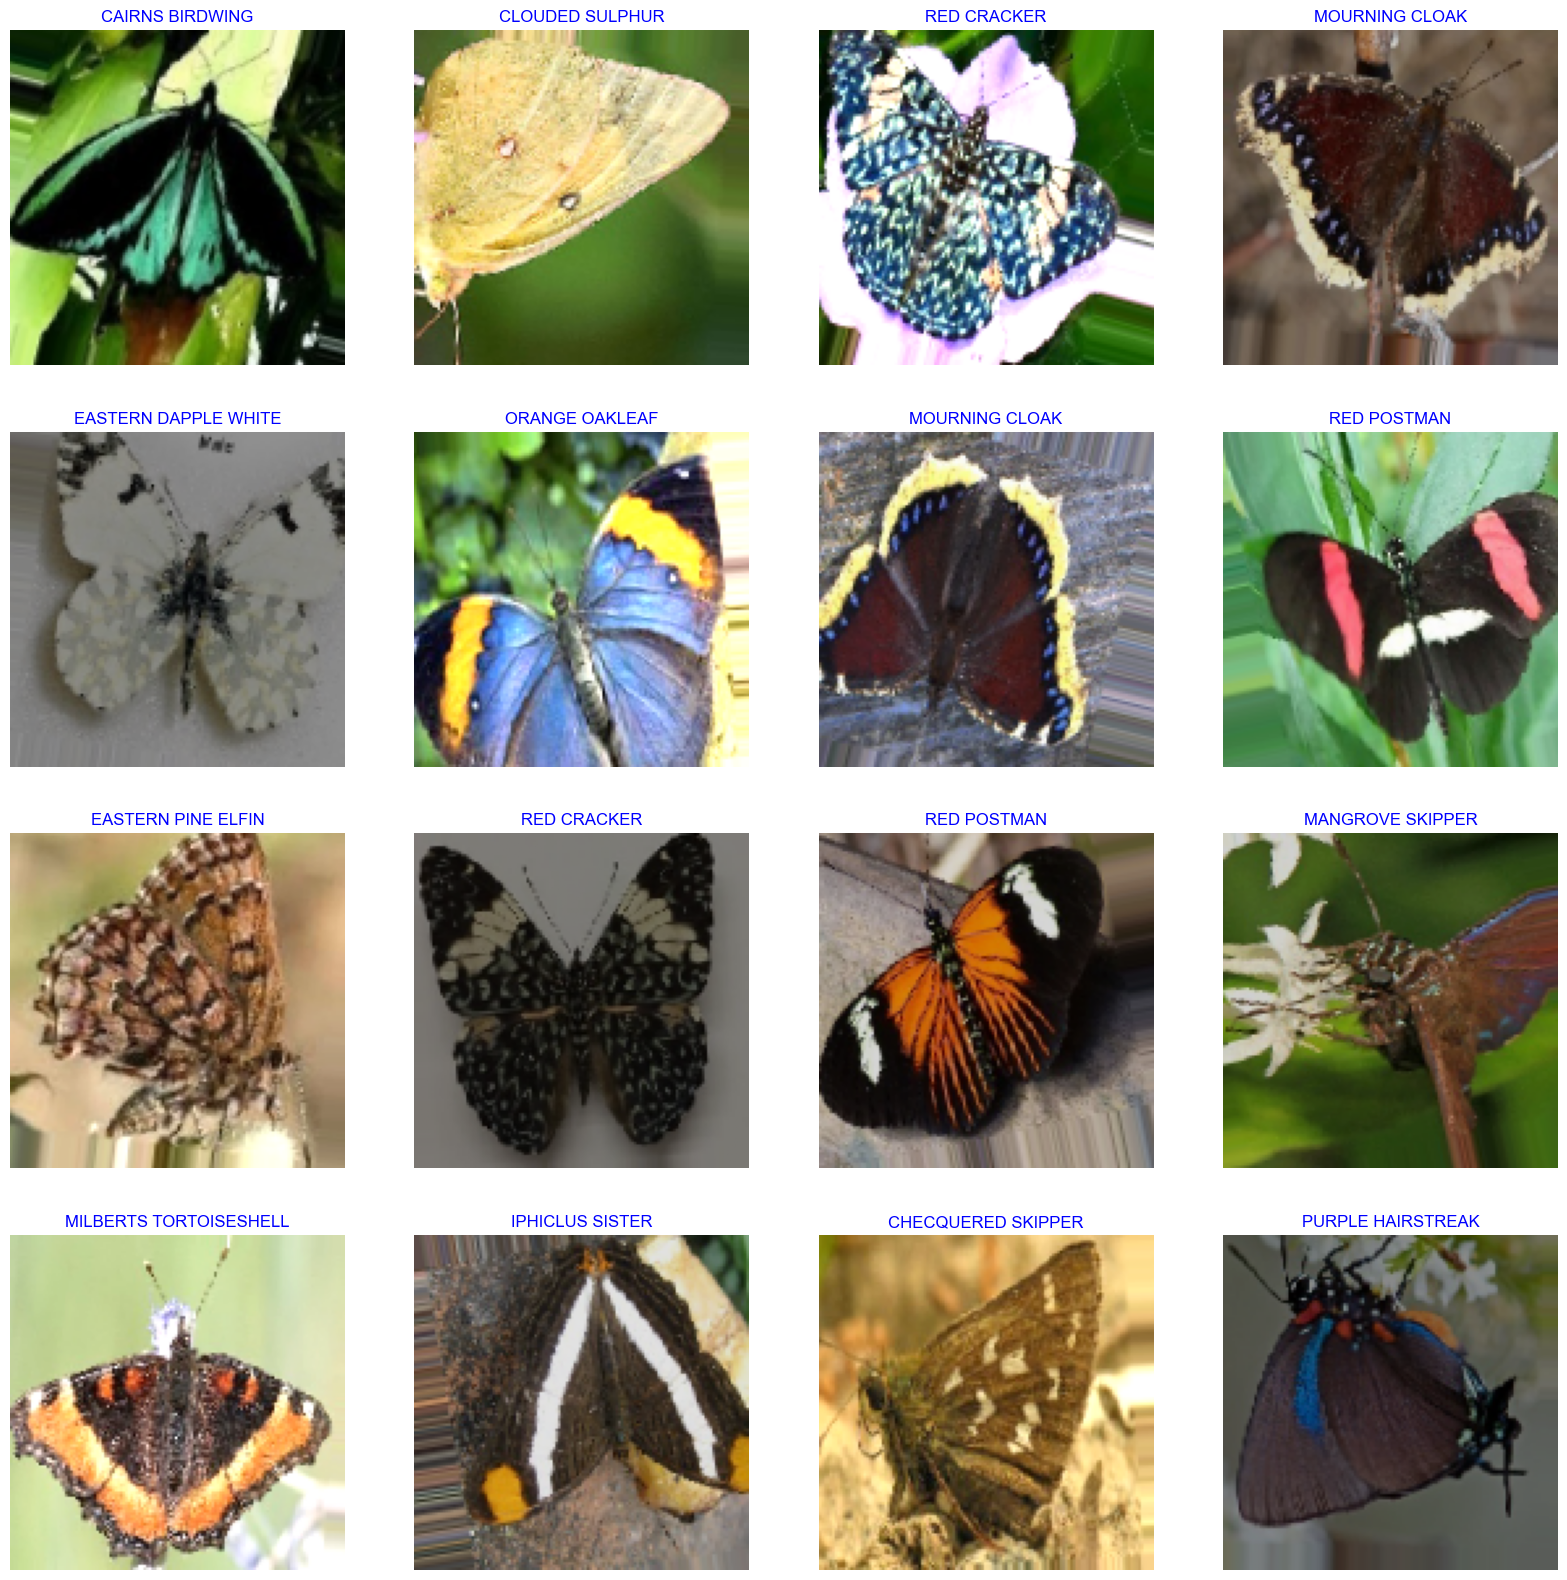

In [145]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [174]:
def create_cnn_model():
    model = Sequential()

    model.add(Conv2D(16, (3, 3), padding='same', input_shape=(128, 128, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))

    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))

    model.add(Flatten())
    model.add(Dense(NUM_CLASSES, activation='softmax'))

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )

    return model


In [175]:
NUM_CLASSES = 75 

cnn_model = create_cnn_model()
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=15
)
history = cnn_model.fit(train_gen, epochs=EPOCHS, validation_data=valid_gen,
                        validation_steps=25, callbacks=[es])


Epoch 1/150
Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x17e7122a0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x17e7122a0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error

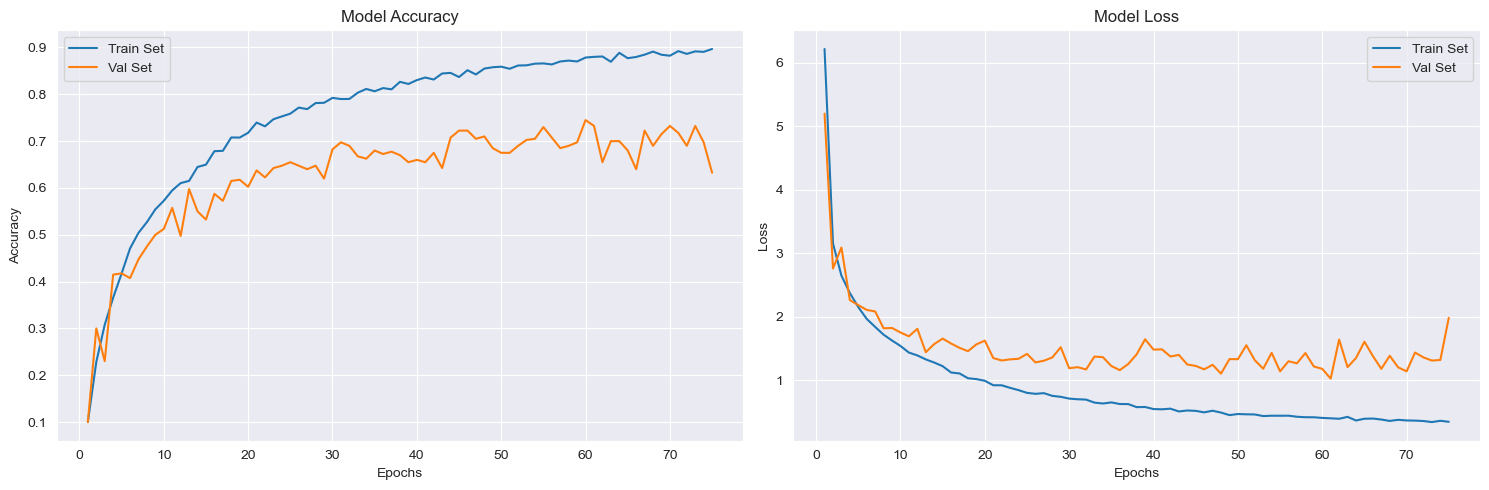

In [176]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [186]:
from sklearn.metrics import precision_recall_fscore_support

predictions = cnn_model.predict(valid_gen, steps=len(valid_gen), verbose=1)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = valid_gen.classes

precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='micro')

print(f"Micro-averaged Precision: {precision:.4f}")
print(f"Micro-averaged Recall: {recall:.4f}")
print(f"Micro-averaged F1 Score: {f1:.4f}")


102/102 [==============================] - 5s 45ms/step
Micro-averaged Precision: 0.0135
Micro-averaged Recall: 0.0135
Micro-averaged F1 Score: 0.0135


In [179]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout

def create_cnn_model1():
    model1 = Sequential()

    model1.add(Conv2D(16, (3, 3), padding='same', input_shape=(128, 128, 3)))
    model1.add(BatchNormalization())
    model1.add(Activation('relu'))
    model1.add(Dropout(0.2))  

    model1.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))

    model1.add(Conv2D(32, (3, 3), padding='same'))
    model1.add(BatchNormalization())
    model1.add(Activation('relu'))
    model1.add(Dropout(0.2))  

    model1.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))

    model1.add(Conv2D(64, (3, 3), padding='same'))
    model1.add(BatchNormalization())
    model1.add(Activation('relu'))
    model1.add(Dropout(0.2))  

    model1.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))

    model1.add(Flatten())
    model1.add(Dense(NUM_CLASSES, activation='softmax'))

    model1.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )

    return model1


In [180]:
NUM_CLASSES = 75 

cnn_model1 = create_cnn_model1()
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=15
)
history1 = cnn_model1.fit(train_gen, epochs=EPOCHS, validation_data=valid_gen,
                        validation_steps=25, callbacks=[es])

Epoch 1/150
Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x17f64a7a0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x17f64a7a0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error

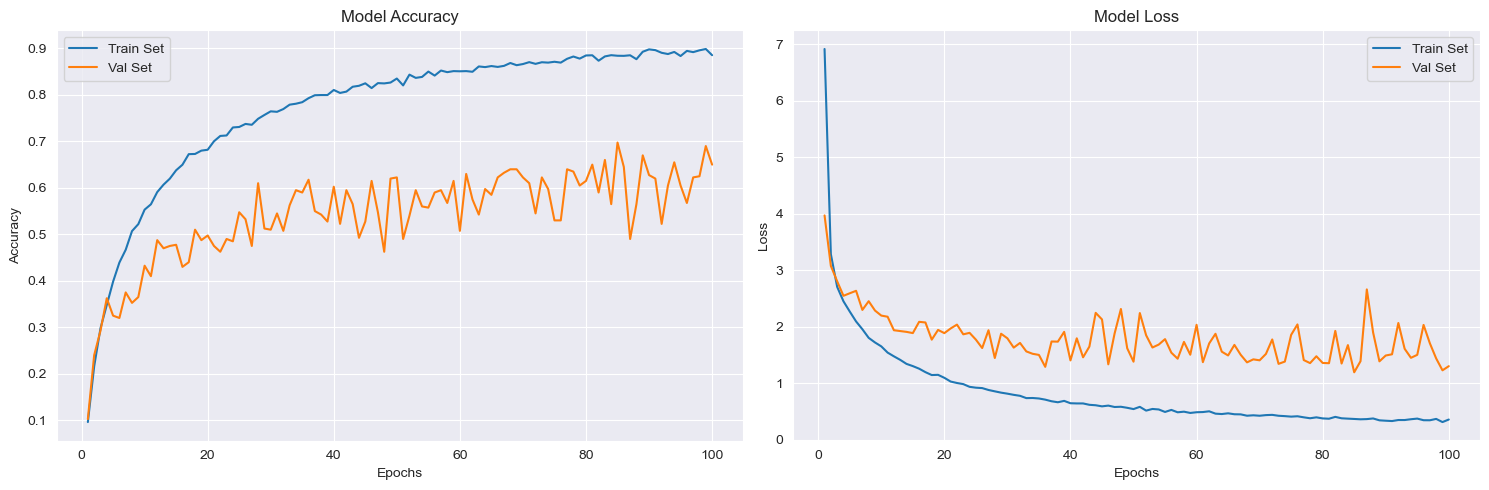

In [181]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs_range = range(1, len(history1.epoch) + 1)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [187]:
from sklearn.metrics import precision_recall_fscore_support

predictions = cnn_model1.predict(valid_gen, steps=len(valid_gen), verbose=1)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = valid_gen.classes

precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='micro')

print(f"Micro-averaged Precision: {precision:.4f}")
print(f"Micro-averaged Recall: {recall:.4f}")
print(f"Micro-averaged F1 Score: {f1:.4f}")


Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x2c36fd120>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x2c36fd120>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: co